In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib .pyplot as plt
%matplotlib inline

from keras.preprocessing import text, sequence

In [124]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [102]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [73]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [101]:
print('trian.info:',train.info())
print('test.info:',test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
trian.info: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
id              153164 non-null object
comment_text    153164 non-null object
dtypes: object(2)
memory usage: 2.3+ MB
test.info: None


In [102]:
'''countdata = train.iloc[:,2:].apply(pd.Series.value_counts)
print (countdata)'''

'countdata = train.iloc[:,2:].apply(pd.Series.value_counts)\nprint (countdata)'

属于1的恶毒标签的相对于0并不多

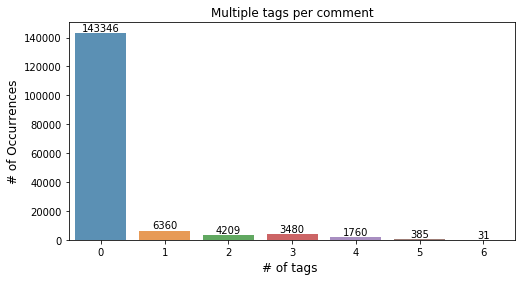

In [103]:
rowsums=train.iloc[:,2:].sum(axis=1)
x = rowsums.value_counts()
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)
 
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

大部分都是1个标签，同时也有很多属于多个标签的

In [104]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

没有空值

In [134]:
X_train = train["comment_text"].values
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test["comment_text"].values

In [ ]:
'''for i in range(len(X_train)):
    j = TextBlob(X_train[i])
    X_train[i] = j.correct()'''

拼写矫正，把错误拼写进行纠正(太消耗时间了，所以放弃了)

In [78]:
repl = {
    "&lt;3": " good ",
    ":d": " good ",
    ":dd": " good ",
    ":p": " good ",
    "8)": " good ",
    ":-)": " good ",
    ":)": " good ",
    ";)": " good ",
    "(-:": " good ",
    "(:": " good ",
    "yay!": " good ",
    "yay": " good ",
    "yaay": " good ",
    "yaaay": " good ",
    "yaaaay": " good ",
    "yaaaaay": " good ",
    ":/": " bad ",
    ":')": " sad ",
    ":-(": " bad ",
    ":(": " bad ",
    ":s": " bad ",
    ":-s": " bad ",
    ":d": " smile ",
    ":p": " smile ",
    ":dd": " smile ",
    "8)": " smile ",
    ":-)": " smile ",
    ":)": " smile ",
    ";)": " smile ",
    "(-:": " smile ",
    "(:": " smile ",
    ":/": " worry ",
    ":')": " sad ",
    ":-(": " sad ",
    ":(": " sad ",
    ":s": " sad ",
    ":-s": " sad ",
    "m": "am",
    "r": "are",
    "u": "you",
    "haha": "ha",
    "hahaha": "ha",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "can't": "can not",
    "cannot": "can not",
    "i'm": "i am",
    "m": "am",
    "i'll" : "i will",
    "its" : "it is",
    "it's" : "it is",
    "'s" : " is",
    "that's" : "that is",
    "weren't" : "were not",
}

In [126]:
keys = [i for i in repl.keys()]

In [127]:
X_train[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [138]:
def preproces(data):
    data_pre = data
    for i in range(len(data)):
        data_pre[i] = text.text_to_word_sequence(data[i],filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',lower = True,split = ' ')
    for i in range(len(data_pre)):
        for j in range(len(data_pre[i])):
            if data_pre[i][j] in keys:
                data_pre[i][j] = repl[data_pre[i][j]]
        data_pre[i] = ','.join(data_pre[i])
    return data_pre

去掉特殊符号，并且用单词替换掉可能存在的颜文字，用正确的拼写替换掉部分缩写

In [139]:
X_train_pre = preproces(X_train)
X_test_pre = preproces(X_test)

In [130]:
X_train_pre[0]

'explanation,why,the,edits,made,under,my,username,hardcore,metallica,fan,were,reverted,they,were,not,vandalisms,just,closure,on,some,gas,after,i,voted,at,new,york,dolls,fac,and,please,do,not,remove,the,template,from,the,talk,page,since,i,am,retired,now,89,205,38,27'

In [140]:
train["comment_text"] = X_train_pre
test["comment_text"] = X_test_pre

In [141]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"explanation,why,the,edits,made,under,my,userna...",0,0,0,0,0,0
1,000103f0d9cfb60f,"d'aww,he,matches,this,background,colour,i,am,s...",0,0,0,0,0,0
2,000113f07ec002fd,"hey,man,i,am,really,not,trying,to,edit,war,it,...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"more,i,can,not,make,any,real,suggestions,on,im...",0,0,0,0,0,0
4,0001d958c54c6e35,"you,sir,are,my,hero,any,chance,you,remember,wh...",0,0,0,0,0,0


In [142]:
train.to_csv('train_pre2.csv',index=None)
test.to_csv('test_pre2.csv',index=None)